# Import packages

In [1]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 16-02-2022
# --- Last Modified: Thu 17 Feb 2022 00:34:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Evaluate Navigators with a pretrained attr discrim network.
"""
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import lpips

import legacy

In [2]:
generator_pkl = 'ffhq512'
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_atl_fixedES_neig30_ffhq512_1/00008-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedES-neig_30-afc_3-nfc_3-atl_14-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_1-kimg1000-batch28/network-snapshot-001000.pkl'
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pcabase_ffhq512/00002-ffhq512-z_50-lr_0.01-wals_1-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_none-nt_pca-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0-ncol_2-dys_T-vars_0.5-kimg80-batch6/network-snapshot-init.pkl'
# attr_discrim_pkl = '/mnt/hpc_hdd_2/repo_results/stylegan2/results_vc2_byvae_ffhq512/00033-vc2_gan-ffhq-4gpu-config-c/converted_ps_sc/00000-convert/attr_discrim_model/00005-00012-pseudo_attr_data-attr-ch_3-dout_24-netn_resnet50-pretr_True-loss_reg-tsize_17000-kimg25000-batch64-noaug/network-snapshot-002016.pkl'
attr_discrim_pkl = '/lshare/xqzhu/ps_sc_pretrained_attr_discrim/network-snapshot-002016.pkl'

used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17] # more accurate

seed = 2022
#outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00028-ffhq512-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_16-dys_T-vars_0.5-kimg160-batch32/eval_nav'
# outdir = os.path.join(os.path.dirname(navigator_pkl), 'eval_nav')
# outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/compare_navs'
outdir = '/lshare/xqzhu/repo_results/stylegan2-ada-pytorch/aaai23_eval_results'
n_samples_per = 1000
batch_gpu = 128
truncation_psi = 1

torch.cuda.device_count()

4

In [3]:
print('Loading generator networks from "%s"...' % generator_pkl)

resume_specs = {
    'ffhq256':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
    'ffhq512':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
    'ffhq1024':    'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
    'celebahq256': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
    'lsundog256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
}

assert generator_pkl is not None
if generator_pkl in resume_specs:
    generator_pkl = resume_specs[generator_pkl] # predefined url

device = torch.device('cuda:0')
gpu_ids = list(range(torch.cuda.device_count()))
# device = torch.device('cpu')
with dnnlib.util.open_url(generator_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].requires_grad_(False) # type: ignore

def load_M(navigator_pkl):
    with open(navigator_pkl, 'rb') as f:
        resume_data = pickle.load(f)
        M = resume_data['M'].requires_grad_(False)
    return M

with open(attr_discrim_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    D = resume_data['D_ema'].requires_grad_(False)

if len(gpu_ids) > 1:
    G = nn.DataParallel(G).to(device)
    G_ref = G.module
    G_mapping = nn.DataParallel(G_ref.mapping).to(device)
    G_synthesis = nn.DataParallel(G_ref.synthesis).to(device)
    D = nn.DataParallel(D).to(device)
    D_ref = D.module
else:
    G_ref = G.to(device)
    G_mapping = G_ref.mapping.to(device)
    G_synthesis = G_ref.synthesis.to(device)
    D_ref = D.to(device)
    
print(gpu_ids)
print('Done loading.')

Loading generator networks from "ffhq512"...
[0, 1, 2, 3]
Done loading.


In [4]:
print(G_mapping)

DataParallel(
  (module): MappingNetwork(
    (fc0): FullyConnectedLayer()
    (fc1): FullyConnectedLayer()
    (fc2): FullyConnectedLayer()
    (fc3): FullyConnectedLayer()
    (fc4): FullyConnectedLayer()
    (fc5): FullyConnectedLayer()
    (fc6): FullyConnectedLayer()
    (fc7): FullyConnectedLayer()
  )
)


In [5]:
os.makedirs(outdir, exist_ok=True)

In [6]:
def show(img):
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [7]:
def try_var_scale_ls(M, var_scale_ls, idx, used_dims, seed=0, truncation_psi=0.3):
    torch.random.manual_seed(seed)
    z = torch.randn([1, G_ref.z_dim], device=device)
    c = torch.randn([1, G_ref.c_dim], device=device)
    w = G_ref.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)
    dirs = M(w) # [b, nv_dim, num_ws, w_dim]
    print('dirs.shape', dirs.shape)
    w_1 = w - dirs[:, used_dims[idx]] * var_scale_ls[idx]
    w_2 = w + dirs[:, used_dims[idx]] * var_scale_ls[idx] # [b, num_ws, w_dim]
    print(idx)
    image = G_ref.synthesis(w_1, noise_mode='const')
    image_2 = G_ref.synthesis(w_2, noise_mode='const')
    print(image.shape)

    show(torch.cat([image, image_2], dim=3)[0].cpu())
# try_var_scale_ls(M, var_scale_ls=[1] * M.nv_dim, idx=0, seed=20)

In [8]:
# Eval for each variation dim
# var_scale_ls = [5, 1, 1, 1, 5, 3, 1, 3, 5, 5]
#var_scale_ls = [1] * M.nv_dim

def evaluate_model(G, M, D, var_scale_ls=[2]*30, used_dims=[1,2,3], truncation_psi=0.5, n_samples_per=500, batch_gpu=16):
    attr_score_shift_summary_ls = []
    img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    rand_state = np.random.RandomState()
    for i, dim in enumerate(used_dims):
        attr_score_shift_ls = []
        print(f'Processing dim {i}')
        for j in range(0, n_samples_per, batch_gpu):
            b = batch_gpu if j+batch_gpu <= n_samples_per else n_samples_per-j

            z = torch.from_numpy(rand_state.randn(b, G_ref.z_dim)).to(device)
            c = torch.from_numpy(rand_state.randn(b, G_ref.c_dim)).to(device)
            w = G_mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

            dirs = M(w) # [b, nv_dim, num_ws, w_dim]
#             print('dirs.shape:', dirs.shape)
#             print('var_scale_ls:', var_scale_ls)
#             print('dim:', dim)
#             print('i:', i)
            w_1 = w - dirs[:, dim] * var_scale_ls[i]
            w_2 = w + dirs[:, dim] * var_scale_ls[i] # [b, num_ws, w_dim]

            images = torch.cat([G_synthesis(w_1, noise_mode='const'),
                                G_synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
            # Normalize to fit model D
            # images_flat = images.view(2*b, -1)
            # img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
            # images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
            images = (images + 1.) / 2. # From [-1, 1] to [0, 1]
            images = (images - img_mean) / img_std
        
            attr_pred = D(images) # [2b, nlabel]
            attr_score_shift = attr_pred[b:] - attr_pred[:b] # [b, nlabel]
            attr_score_shift_ls.append(attr_score_shift.to('cpu'))
        attr_score_shift_i = torch.cat(attr_score_shift_ls, dim=0).mean(0) # [nlabel]
        attr_score_shift_summary_ls.append(attr_score_shift_i)
    return attr_score_shift_summary_ls

In [9]:
def summarize(attr_score_shift_summary_ls, name='pca'):
    attr_score_shift_summary = torch.stack(attr_score_shift_summary_ls, dim=0) # [nv_dim, nlabel]
    print(attr_score_shift_summary.shape)

    scores_np = np.abs(attr_score_shift_summary.numpy())
    scores_normed = scores_np[:, used_attr_idx] / scores_np[:, used_attr_idx].max(axis=1, keepdims=True)
    
    scores_copy = scores_np.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:30, -1] - scores_copy[:30, -2]).mean()
    print('before normed:', score)
    
    scores_copy = scores_normed.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:30, -1] - scores_copy[:30, -2]).mean()
    print('after normed:', score)
    
    attr_discovered = (scores_normed[:30] == 1.).any(axis=0)
    n_discovered = attr_discovered.sum()
    print('attr_discovered:', attr_discovered)
    print('n_discovered:', n_discovered)
    
    plt.clf()
    plt.imshow(scores_normed[:30], cmap='viridis')
    # plt.imshow(scores_np[:30], cmap='viridis')
    plt.colorbar()
    #plt.show()
    plt.savefig(os.path.join(outdir, f'attr_score_shift_{name}.pdf'))
    np.savetxt(os.path.join(outdir, f"scores_raw_{name}.csv"), scores_np, delimiter=",")
    np.savetxt(os.path.join(outdir, f"scores_normed_{name}.csv"), scores_normed, delimiter=",")
    np.savetxt(os.path.join(outdir, f"score_{name}.csv"), score[np.newaxis], delimiter=",")
    np.savetxt(os.path.join(outdir, f"n_discovered_{name}.csv"), n_discovered[np.newaxis], delimiter=",")
    return score

In [10]:
# used_dims = argsort_percept(G, M, D)
def argsort_percept(G, M, n_samples_dim=100):
    if len(gpu_ids) > 1:
        pnet = nn.DataParallel(lpips.LPIPS(net='alex', lpips=False)).to(device)
    else:
        pnet = lpips.LPIPS(net='alex', lpips=False).to(device)
    img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    rand_state = np.random.RandomState()
    percept_ls = []
    for i in range(M_ref.nv_dim):
        print('computing dim:', i)
        diff_ls_i = []
        for j in range(0, n_samples_dim, batch_gpu):
            b = batch_gpu if j+batch_gpu <= n_samples_per else n_samples_per-j

            z = torch.from_numpy(rand_state.randn(b, G_ref.z_dim)).to(device)
            c = torch.from_numpy(rand_state.randn(b, G_ref.c_dim)).to(device)
            w = G_mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

            # print(M.device)
            print(w.device)
            print(w.shape)
            dirs = M(w) # [b, nv_dim, num_ws, w_dim]
            w_1 = w - dirs[:, i]
            w_2 = w + dirs[:, i] # [b, num_ws, w_dim]

            images = torch.cat([G_synthesis(w_1, noise_mode='const'),
                                G_synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
            # Normalize to fit model D
            # images_flat = images.view(2*b, -1)
            # img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
            # images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
            images = (images + 1.) / 2. # From [-1, 1] to [0, 1]
            images = (images - img_mean) / img_std
            
            diff = pnet(images[:b], images[b:]).squeeze() # [b]
            diff_ls_i.append(diff.to('cpu'))
        print(diff_ls_i)
        diff_i_sum = torch.cat(diff_ls_i, dim=0).sum()
        percept_ls.append(diff_i_sum)
    percept = torch.tensor(percept_ls, device=device)
    _, idx_sort = torch.sort(percept, descending=True)
    return idx_sort
        

In [39]:
attr_names = ['azimuth',#0
                'haircolor',#1
                'smile',#2
                'gender',#3
                'main_fringe',#4
                'left_fringe',#5
                'age',#6
                'light_right',#7
                'light_left',#8
                'light_vertical',#9
                'hair_style',#10
                'clothes_color',#11
                'saturation',#12
                'ambient_color',#13
                'elevation',#14
                'neck',#15
                'right_shoulder',#16
                'left_shoulder',#17
                'background_1',#18
                'background_2',#19
                'background_3',#20
                'background_4',#21
                'right_object',#22
                'left_object']#23
# used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17] # more accurate
used_attr_idx = list(range(24))
# === contra-1 not goood
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_atl_fixedES_neig30_ffhq512_1/00008-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedES-neig_30-afc_3-nfc_3-atl_14-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_1-kimg1000-batch28/network-snapshot-001000.pkl'
# === contra-2
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_fixedE100_ffhq512_1/00004-ffhq512-z_50-lr_0.05-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_3-kimg600-batch10/network-snapshot-000600.pkl'
# navigator_pkl = '/lshare/xqzhu/repo_results/stylegan2-ada-pytorch/nav_aaai23_bi_z64_200k_ffhq512/00000-ffhq512-z_64-lr_0.1-vars_0.5-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_300-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.01-ncol_16-dys_T-kimg200-batch8/network-snapshot-000200.pkl'
# navigator_pkl = '/lshare/xqzhu/repo_results/stylegan2-ada-pytorch/nav_aaai23_bi_z64_200k_ffhq512/00001-ffhq512-z_64-lr_0.1-vars_0.5-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_300-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.01-ncol_16-dys_T-kimg200-batch8/network-snapshot-000200.pkl'
# navigator_pkl = '/lshare/xqzhu/repo_results/stylegan2-ada-pytorch/nav_aaai23_bi_z64_200k_ffhq512/00002-ffhq512-z_64-lr_0.1-vars_0.5-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_300-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.01-ncol_16-dys_T-kimg200-batch8/network-snapshot-000200.pkl'
navigator_pkl = '/lshare/xqzhu/repo_results/stylegan2-ada-pytorch/nav_aaai23_bi_z64_200k_ffhq512/00003-ffhq512-z_64-lr_0.1-vars_0.5-wals_0.3-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_300-afc_3-nfc_3-atl_16-atg_3-cont_1-pos_1-neg_1-div_0.01-ncol_16-dys_T-kimg200-batch8/network-snapshot-000200.pkl'
# === pca_base
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pcabase_ffhq512/00002-ffhq512-z_50-lr_0.01-wals_1-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_none-nt_pca-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0-ncol_2-dys_T-vars_0.5-kimg80-batch6/network-snapshot-init.pkl'
# === sefa_base
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_sefabase_ffhq512/00000-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_none-nt_sefa-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg1-batch24/network-snapshot-init.pkl'
# === recog-at_fixed-nv_fixed
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_recogbase_ffhq512/00002-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-mcont_0-sensor_alex-Rpre_T-recg_1-vs_0.25-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixed-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg1000-batch8/network-snapshot-001000.pkl'
M = load_M(navigator_pkl)
# if len(gpu_ids) > 1:
#     M = nn.DataParallel(M)
#     M.to(device)
#     M_ref = M.module
# else:
#     M_ref = M.to(device)
M_ref = M.to(device)
print(M.nv_dim)
print('Done')

64
Done


In [40]:
used_dims = argsort_percept(G, M, n_samples_dim=20) # [4,2,6,10]
print('used_dims:', used_dims)

Setting up [baseline] perceptual loss: trunk [alex], v[0.1], spatial [off]
computing dim: 0
cuda:0
torch.Size([128, 16, 512])
[tensor([6.1657, 7.0125, 6.7202, 6.9392, 6.3029, 6.1660, 5.3717, 5.1899, 6.3474,
        5.8584, 6.1475, 6.7780, 6.0277, 6.2285, 6.1657, 5.7130, 6.3852, 6.1825,
        6.1150, 6.3515, 6.5368, 5.9380, 6.5957, 6.4629, 5.9415, 6.1001, 5.9982,
        6.0198, 5.8544, 7.2177, 5.9239, 6.4513, 7.3431, 6.0847, 5.3230, 5.6209,
        5.7791, 5.4402, 6.1132, 6.0595, 5.4184, 5.8536, 6.2514, 6.3552, 6.4887,
        6.4803, 6.3618, 6.5641, 6.1188, 4.0314, 5.2550, 5.6828, 5.3750, 6.0474,
        6.2921, 5.2226, 5.6476, 3.8234, 6.4526, 6.5571, 7.0145, 6.9392, 6.0710,
        6.1118, 6.9804, 6.8244, 6.8631, 5.5311, 5.9338, 5.5646, 6.4002, 6.2725,
        6.6031, 6.2275, 6.2520, 5.8912, 5.8656, 5.7735, 6.4066, 5.9270, 6.2917,
        5.7597, 6.3435, 6.0316, 6.7314, 5.5439, 6.5423, 6.5527, 6.2292, 6.3154,
        6.0326, 6.8251, 6.4721, 6.5393, 5.9682, 6.4221, 6.4881, 6.1149, 5

dirs.shape torch.Size([1, 64, 16, 512])
3
torch.Size([1, 3, 512, 512])


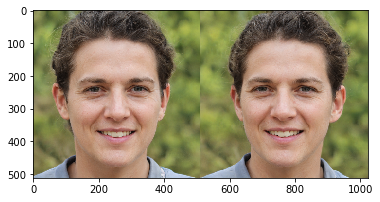

In [41]:
# pca_used_dims = used_dims
# pca_var_scale_ls = [3,3,3,3,3,3,
#                    2,2,2,2,2,2,
#                    2,2,2,2,2,2,
#                    2,2,2,2,2,2,
#                    2,2,2,2,2,2]
# try_var_scale_ls(M, var_scale_ls=pca_var_scale_ls, used_dims=pca_used_dims, idx=29, seed=2001)

# === contra-1
# contra_var_scale_ls = [0.5,5,5,0.5,0.5,1,
#                       1,0.5,0.5,1,0.5,0.5,
#                       0.5,5,1,0.5,0.5,1,
#                       5,1,3,1,0.5,1,
#                       0.5,0.5,3,1,0.5,1]
# try_var_scale_ls(M, var_scale_ls=contra_var_scale_ls, idx=3, seed=112)

# === contra-2
contra2_used_dims = used_dims
# contra2_var_scale_ls = [0.5,0.5,0.5,0.5,0.7,0.5,
#                        0.5,0.5,1,1,0.5,0.7,
#                        0.5,1,1,0.5,1,1,
#                        0.5,0.5,0.7,0.5,0.5,1,
#                        0.5,1,0.5,0.7,1,0.7,]
contra2_var_scale_ls = [0.3] * 64
try_var_scale_ls(M, var_scale_ls=contra2_var_scale_ls, used_dims=contra2_used_dims, idx=3, seed=31)

# sefa_var_scale_ls = [2,3,4,3,3,3,
#                       3,3,3,3,2,2,
#                       2,2,1.5,1.5,1.5,1.5,
#                       1.5,1.5,1.5,1.5,1.5,1.5,
#                       1.5,1.5,1.5,1.5,1.5,1.5]
# try_var_scale_ls(M, var_scale_ls=sefa_var_scale_ls, idx=29, seed=2013)

# recog_var_scale_ls = [0.5,0.5,0.5,0.5,0.5,5,
#                       5,0.5,0.5,5,0.5,0.5,
#                       1,0.5,0.5,0.3,0.5,0.5,
#                       5,1,1,0.5,0.5,5,
#                       0.5,0.3,0.3,0.5,0.5,5]
# try_var_scale_ls(M, var_scale_ls=recog_var_scale_ls, idx=29, seed=2016)

In [42]:
# pca_attr_ls = evaluate_model(G, M, D, var_scale_ls=pca_var_scale_ls, used_dims=pca_used_dims[:len(pca_var_scale_ls)], batch_gpu=32)
# contra_attr_ls = evaluate_model(G, M, D, var_scale_ls=contra_var_scale_ls, max_nv_dim=32)
print(contra2_var_scale_ls)
contra2_attr_ls = evaluate_model(G, M, D, var_scale_ls=contra2_var_scale_ls, used_dims=contra2_used_dims[:len(contra2_var_scale_ls)])
# sefa_attr_ls = evaluate_model(G, M, D, var_scale_ls=sefa_var_scale_ls, used_dims=list(range(30)))
# recog_attr_ls = evaluate_model(G, M, D, var_scale_ls=recog_var_scale_ls, used_dims=list(range(30)))

[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
Processing dim 0
Processing dim 1
Processing dim 2
Processing dim 3
Processing dim 4
Processing dim 5
Processing dim 6
Processing dim 7
Processing dim 8
Processing dim 9
Processing dim 10
Processing dim 11
Processing dim 12
Processing dim 13
Processing dim 14
Processing dim 15
Processing dim 16
Processing dim 17
Processing dim 18
Processing dim 19
Processing dim 20
Processing dim 21
Processing dim 22
Processing dim 23
Processing dim 24
Processing dim 25
Processing dim 26
Processing dim 27
Processing dim 28
Processing dim 29
Processing dim 30
Processing dim 31
Processing dim 32
Processing dim 33
Processing dim 34
Processing dim 35
Processing dim 36
Processing dim 37
Proce

In [43]:
def load_summary(name, limit=30, used_attr_idx=list(range(24))):
    scores_np = np.loadtxt(os.path.join(outdir, f"scores_raw_{name}.csv"), delimiter=",")
    scores_normed = np.loadtxt(os.path.join(outdir, f"scores_normed_{name}.csv"), delimiter=",")
    # score = np.loadtxt(os.path.join(outdir, f"score_{name}.csv"), delimiter=",")
    n_disc = np.loadtxt(os.path.join(outdir, f"n_discovered_{name}.csv"), delimiter=",")
    
    # scores_normed = scores_normed[:, used_attr_idx]
    scores_normed = scores_np[:, used_attr_idx] / scores_np[:, used_attr_idx].max(axis=1, keepdims=True)
    scores_np = scores_np[:, used_attr_idx]

    scores_copy = scores_np.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:limit, -1] - scores_copy[:limit, -2]).mean()
    print('before normed:', score)
    
    scores_copy = scores_normed.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:limit, -1] - scores_copy[:limit, -2]).mean()
    print('after normed:', score)
    
    attr_discovered = (scores_normed[:limit] == 1.).any(axis=0)
    n_discovered = attr_discovered.sum()
    print('attr_discovered:', attr_discovered)
    print('n_discovered:', n_discovered)
    
    plt.clf()
    plt.imshow(scores_normed[:limit], cmap='viridis')
    # plt.imshow(scores_np[:30], cmap='viridis')
    plt.colorbar()
    #plt.show()
    return score

before normed: 0.11865231581032276
after normed: 0.3153917705882405
attr_discovered: [ True False False  True  True False False  True  True False False False
  True False  True False False False  True  True False  True False False]
n_discovered: 10


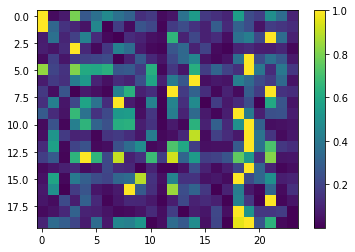

In [14]:
# pca_score = summarize(pca_attr_ls[:30], name='pca')
# pca_score = load_summary('pca', limit=15, used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17])
pca_score = load_summary('pca', limit=20)

torch.Size([64, 24])
before normed: 0.12892245
after normed: 0.36842787
attr_discovered: [ True  True  True False  True False False False  True False False False
  True False  True  True  True False  True  True False  True False False]
n_discovered: 12
before normed: 0.11265495060943068
after normed: 0.3531066885617875
attr_discovered: [ True  True  True False  True False  True False  True False False False
  True False  True  True  True False  True  True False  True False False]
n_discovered: 13


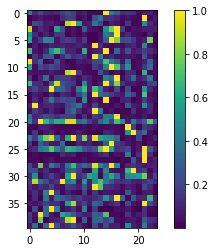

In [46]:
contra2_score = summarize(contra2_attr_ls, name='contra')
# contra2_score = load_summary('contra', limit=30, used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17])
contra2_score = load_summary('contra', limit=40)

In [82]:
# sefa_score = summarize(sefa_attr_ls[:15])
# sefa_score = load_summary('sefa', limit=10)

before normed: 0.10346200689673424
after normed: 0.3671767085790634
attr_discovered: [ True  True  True  True  True False False  True  True False False False
 False False False]
n_discovered: 7


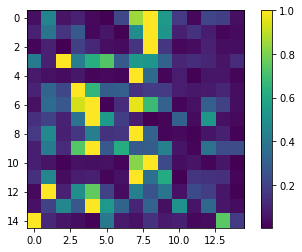

In [104]:
# recog_score = summarize(recog_attr_ls[:15], name='recog')
recog_score = load_summary('recog', limit=50)